In [1]:
# P2 Algorithm for dynamic calculation of quantiles and histograms
# without storing observations
# https://www.cs.wustl.edu/~jain/papers/ftp/psqr.pdf
class P2Algorithm:
    def __init__(self, p, logger=None):
        self.p = p
        self.logger = logger
        self.count = 0
        # marker heights
        self.q = []
        # marker positions
        self.n = list(range(5))
        # initial desired positions
        self.n_prime = list(range(5))

    def observe(self, value):
        # sort the first five observations and use them to set marker heights
        self.count += 1
        if self.count <= 5:
            self.q += [value]
            if self.count == 5:
                self.q.sort()
            return
        self._do_algo(value)

    def _do_algo(self, value):
        # find cell k such that marker_heights[k] <= value < marker_heights[k+1]
        k = self._find_cell(value)
        # update marker 1 or 5 if value is new min or max
        self._update_extremes(value)

        if self.logger:
            self.logger.info(f"Observation number: {self.count}")
            self.logger.info(f"Observed value: {value}")
            self.logger.info(f"Fits after marker: {k+1}")

        # increase of positions marker k+1 through 5 by 1
        for i in range(k + 1, 5):
            self.n[i] += 1

        if self.logger:
            self.logger.info(f"Marker position after observation: {self.n}")

        # update desired positions for all markers
        self.n_prime[1] = (self.count) * self.p / 2
        self.n_prime[2] = (self.count) * self.p
        self.n_prime[3] = (self.count) * (1 + self.p) / 2
        self.n_prime[4] = self.count

        if self.logger:
            self.logger.info(f"Desired marker position: {self.n_prime}")

        self._update_marker_positions()

        if self.logger:
            self.logger.info(f"New marker positions: {self.n}")
            self.logger.info(f"Marker heights: {self.q}")
            self.logger.info("-" * 50)

    def _find_cell(self, value):
        if value < self.q[0]:
            return 0
        return next((i for i in range(4) if self.q[i] <= value < self.q[i + 1]), 3)

    def _update_extremes(self, value):
        self.q[0] = min(self.q[0], value)
        self.q[4] = max(self.q[4], value)

    def _update_marker_positions(self):
        adjusted = []
        for i in range(1, 4):
            d = self.n_prime[i] - self.n[i]
            move_right = d >= 1 and (self.n[i + 1] - self.n[i]) > 1
            move_left = d <= -1 and (self.n[i] - self.n[i - 1]) > 1
            if move_right or move_left:
                adjusted += [i]
                d = -1 if d < 0 else 1  # get sign of d
                q_temp = self._p2_interpolation(d, i)
                if self.q[i - 1] < q_temp < self.q[i + 1]:
                    self.q[i] = q_temp
                else:
                    self.q[i] = self._linear_interpolation(d, i)
                self.n[i] += d

        if self.logger:
            self.logger.info(f"Adjust markers: {adjusted}")

    def _p2_interpolation(self, d, i):
        return self.q[i] + d / (self.n[i + 1] - self.n[i - 1]) * (
            (self.n[i] - self.n[i - 1] + d)
            * (self.q[i + 1] - self.q[i])
            / (self.n[i + 1] - self.n[i])
            + (self.n[i + 1] - self.n[i] - d)
            * (self.q[i] - self.q[i - 1])
            / (self.n[i] - self.n[i - 1])
        )

    def _linear_interpolation(self, d, i):
        return self.q[i] + d * (self.q[i + d] - self.q[i]) / (self.n[i + d] - self.n[i])

    @property
    def quantile(self):
        return self.q[2]


In [2]:
import sys
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import logging
import numpy as np
from functools import partial

flag = False

def main(iterations, p=0.5, distribution=partial(np.random.normal, size=100), verbose=False):
    # set up logging
    global flag
    if verbose:
        logger = logging.getLogger("P2")
        if flag:
            logger.addHandler(logging.StreamHandler(stream=sys.stdout))
            flag = False
        logger.setLevel(logging.DEBUG)
    else:
        logger = None

    true_medians = []
    p2_medians = []
    all_observations = []

    for _ in range(iterations):
        p2 = P2Algorithm(p, logger=logger)
        data = distribution()
        for value in data:
            p2.observe(value)
        all_observations += [data]
        

        true_medians += [np.median(data)]
        p2_medians += [p2.quantile]
    
    return true_medians, p2_medians, all_observations

# 500 Iterations of P2 Estimator with Data Size 250

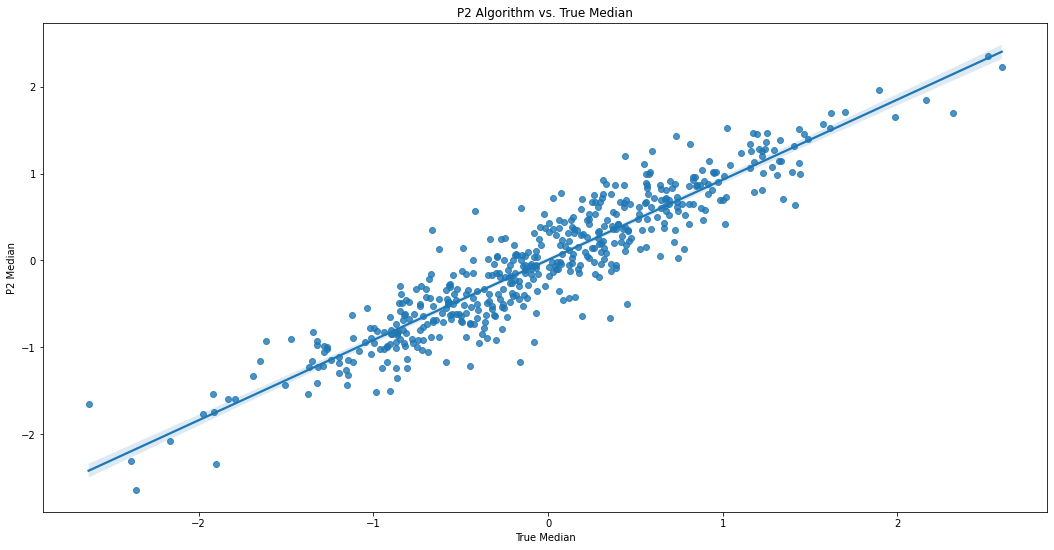

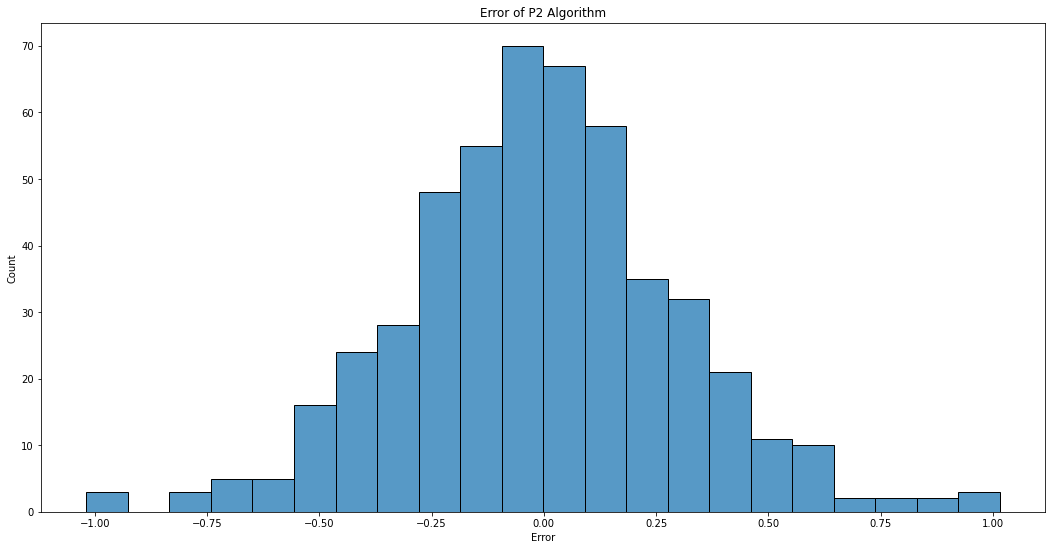

In [3]:
distribution = partial(np.random.normal, loc=0, scale=10, size=250)

true_medians, p2_medians, observations = main(iterations=500, distribution=distribution)

results = pd.DataFrame({"true_median": true_medians, "p2_median": p2_medians})
plt.figure(figsize=(18, 9))
sns.regplot(x="true_median", y="p2_median", data=results).set(title="P2 Algorithm vs. True Median", xlabel="True Median", ylabel="P2 Median")

error = results["true_median"] - results["p2_median"]
plt.figure(figsize=(18, 9))
sns.histplot(data=error).set(title="Error of P2 Algorithm", xlabel="Error", ylabel="Count")

plt.show()


# Sample of Iterations

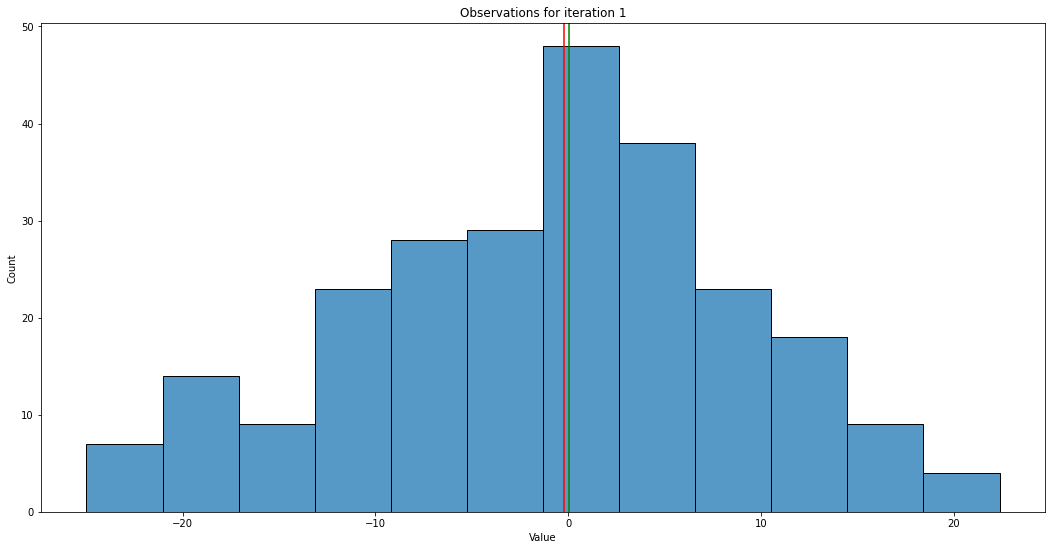

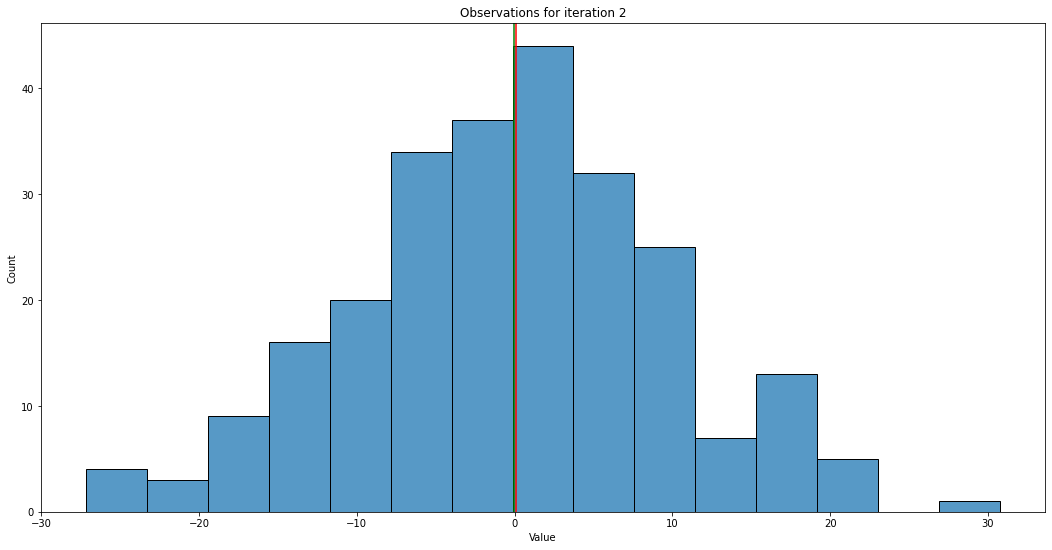

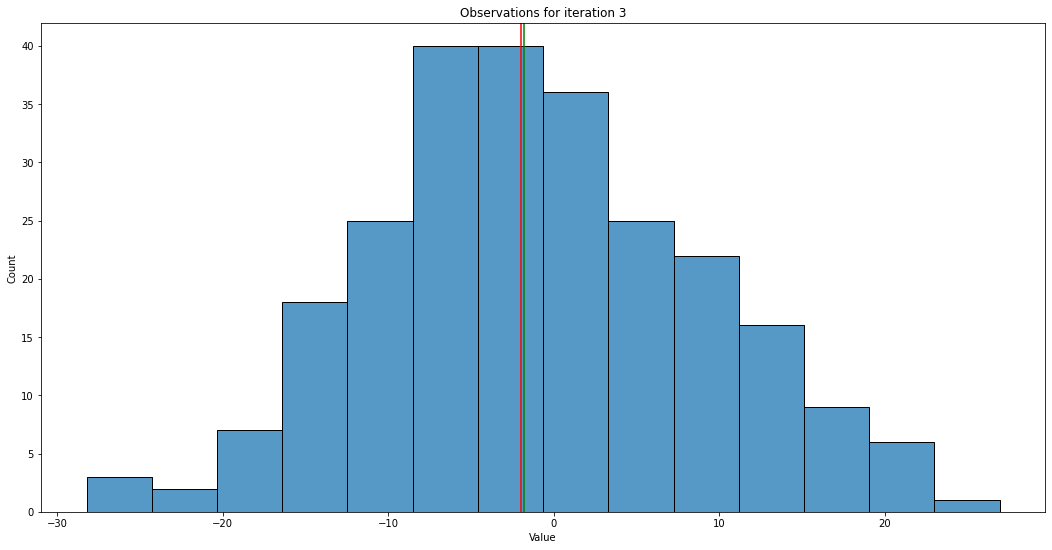

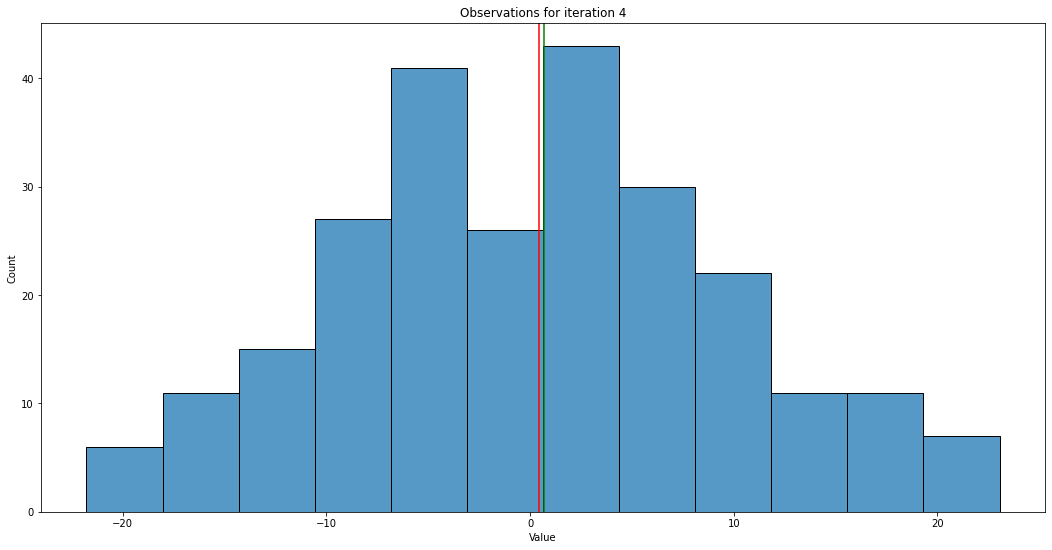

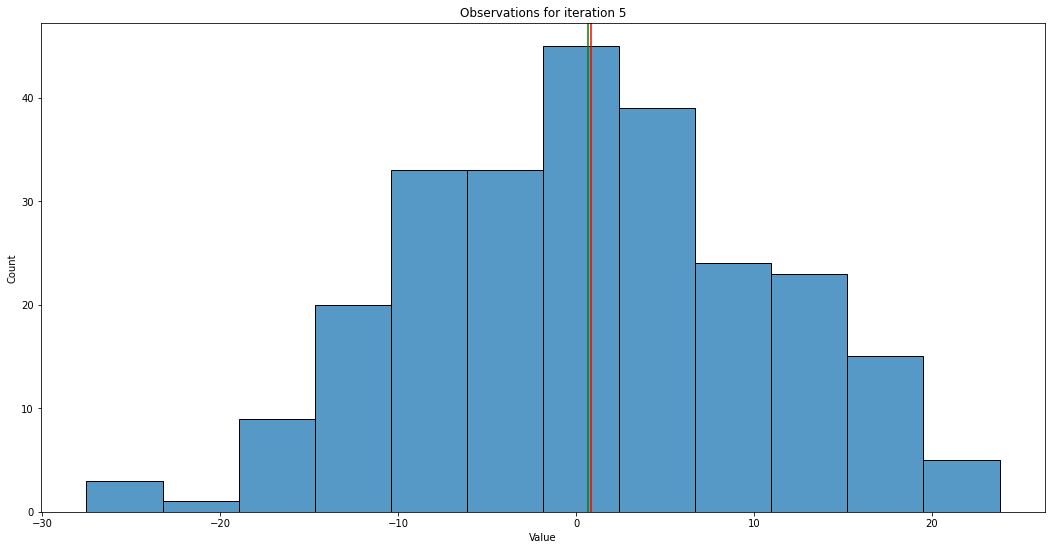

In [4]:
for i in range(5):
    plt.figure(figsize=(18, 9))
    ax = sns.histplot(observations[i])
    ax.set(title=f"Observations for iteration {i+1}", xlabel="Value", ylabel="Count")
    ax.axvline(results["true_median"][i], color="red", label="True Median")
    ax.axvline(results["p2_median"][i], color="green", label="P2 Median")

plt.show()